In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt

import utilitary as util

In [3]:
hf = h5py.File("../epfl4.h5", "r")

In [4]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)
x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

In [5]:
r_MIP = util.red_MIP(hf, list_keys[:50], axis = 2)

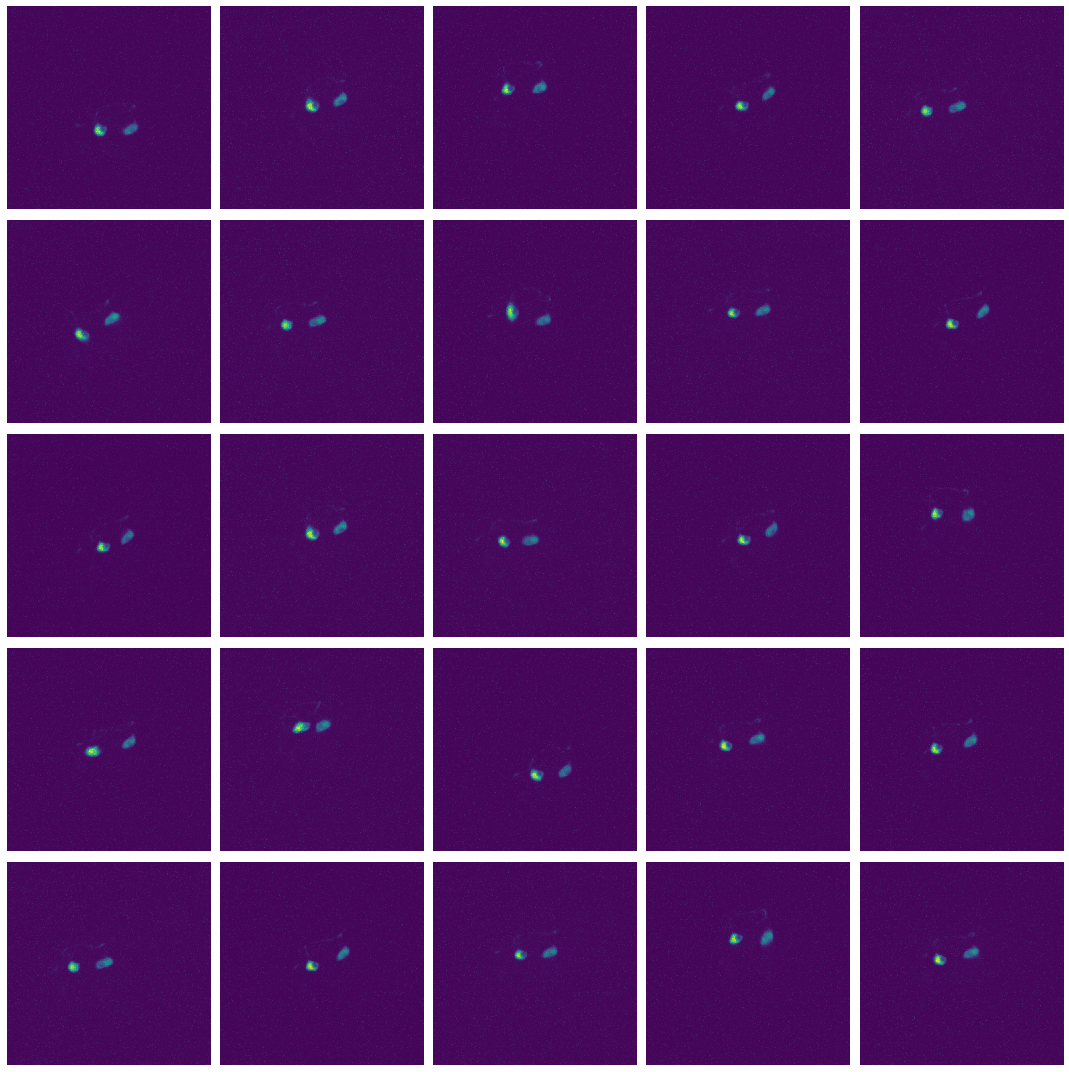

In [6]:
# Plot true RGB MIP images
i=5
j=5
idx= np.random.randint(0,50,i*j)
plots = [r_MIP[i] for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [ ]:
MIP, _ = util.find_contour(r_MIP,0.8,blur=5)

# Plot true RGB MIP images
i=5
j=5
plots = [MIP[i] for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [ ]:
plots = [util.crop_ctr_mass(r_MIP[i]) for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [ ]:
plots = [util.crop_ctr_mass(MIP[i]) for i in idx]
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [ ]:
from scipy import ndimage
#vizualize the center of mass
idx = np.random.randint(0,50)

(x, y) = ndimage.center_of_mass(MIP[idx])
x, y = int(x), int(y)
bis = MIP[idx]
coord = [(x-i,y-j) for i in range(0,4) for j in range(0,4)]
for pos in coord:
    bis[pos] = 0.5
ne.plot.slices(bis, do_colorbars=True, grid = [1,1]);

In [ ]:
#
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]


#train on contours
#projection on z plan
r_MIP = util.red_MIP(hf, list_keys, axis = 2)

#find the contour
contours, all_ret = util.find_contour(r_MIP)

In [ ]:
#cropping center of mass
#slices_train = np.array([util.crop_ctr_mass(r_MIP[i],200) for i in keys_train])
#slices_test  = np.array([util.crop_ctr_mass(r_MIP[i],200) for i in keys_test])
slices_train = np.array([util.crop_ctr_mass(contours[i],128) for i in keys_train])
slices_test  = np.array([util.crop_ctr_mass(contours[i],128) for i in keys_test])

In [ ]:
plots = [slices_train[i] for i in [7,2,5,98]]
ne.plot.slices(plots, do_colorbars=True, grid = [2,2]);

print(slices_train.shape)

In [ ]:
# UNET architecture

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,5)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 20)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [ ]:
# Load the best weights found
title = "weights" + str(lambdas[-2]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 12, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

In [ ]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

In [ ]:
slices_train = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_train])
slices_test  = np.array([util.crop_ctr_mass(r_MIP[i],128) for i in keys_test])

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,5)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
    # vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 20)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=1);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "weights_rchan" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [ ]:
# Load the best weights found
title = "weights_rchan" + str(lambdas[-1]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 52, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);